# 0.0 IMPORTS


In [98]:
from sklearn.model_selection import GridSearchCV
from boruta import BorutaPy
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,                
    recall_score,
    log_loss
)

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import time
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# %pip install pandas
# %pip install numpy
# %pip install scikit-learn
# %pip install matplotlib
# %pip install plotly
# %pip install ipykernel
# %pip install nbformat
# %pip install --upgrade nbformat
# %pip install holoviews
# %pip install hvplot
# %pip install seaborn
# %pip install mlxtend
# %pip install xgboost
# %pip install scikit-
# %pip install Boruta
# %pip install scipy

## 0.1 Helper Functions

### 0.1.1 Graphs

In [99]:
from graphs.bar_nominal import bar_plot_nominal
from graphs.bar_unique import bar_plot_unique_var
from graphs.bar_ordinal import bar_plot_ordinal
from graphs.violin import plot_violin
from graphs.bar_index import bar_plot_index
from graphs.violin_percent import plot_violin_percent
from graphs.violin_log import plot_violin_log

### 0.1.2 Evaluate Models

In [100]:
def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }
    if y_proba is not None:  # Only if the model supports predict_proba
        metrics["ROC-AUC"] = roc_auc_score(y_true, y_proba[:, 1])  # Use probabilities of the positive class
        metrics["Log Loss"] = log_loss(y_true, y_proba)
    return metrics

## 0.2 Path Definition

In [113]:
csv_path = 'loan_data.csv'

## 0.3 Load Data

In [143]:
# Upload data
df = pd.read_csv(csv_path)
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# 1.0 DATA DESCRIPTION

## 1.1 Data fields

Overview
This dataset contains 45,000 records of loan applicants, with various attributes related to personal demographics, financial status, and loan details. The dataset can be used for predictive modeling, particularly in credit risk assessment and loan default prediction.

Dataset Content
The dataset includes 14 columns representing different factors influencing loan approvals and defaults:

Personal Information

person_age: Age of the applicant (in years).
person_gender: Gender of the applicant (male, female).
person_education: Educational background (High School, Bachelor, Master, etc.).
person_income: Annual income of the applicant (in USD).
person_emp_exp: Years of employment experience.
person_home_ownership: Type of home ownership (RENT, OWN, MORTGAGE).

Loan Details
loan_amnt: Loan amount requested (in USD).
loan_intent: Purpose of the loan (PERSONAL, EDUCATION, MEDICAL, etc.).
loan_int_rate: Interest rate on the loan (percentage).
loan_percent_income: Ratio of loan amount to income.

Credit & Loan History
cb_person_cred_hist_length: Length of the applicant's credit history (in years).
credit_score: Credit score of the applicant.
previous_loan_defaults_on_file: Whether the applicant has previous loan defaults (Yes or No).

Target Variable
loan_status: 1 if the loan was repaid successfully, 0 if the applicant defaulted.

Use Cases
Loan Default Prediction: Build a classification model to predict loan repayment.
Credit Risk Analysis: Analyze the relationship between income, credit score, and loan defaults.
Feature Engineering: Extract new insights from employment history, home ownership, and loan amounts.

Acknowledgments

This dataset is synthetic and designed for machine learning and financial risk analysis.

## 1.2 Rename Columns

Fields are appropriate to begin the development of the solution.

## 1.3 Data Types

In [144]:
df.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

## 1.4 Check NANs

In [146]:
# Check if there is null values
if df.isnull().sum().sum() != 0:
  print(df.dropna(inplace=True))
  print('Duplicated Rows Removed!')
else:
  print('No Duplicated Rows in the dataset')

No Duplicated Rows in the dataset


## 1.5 Fillout NaNs

There is no need to remove NANs values of the dataset.

## 1.6 Change Types

In [147]:
df = df.astype({
    "person_age": np.dtype("int"),
    "person_gender": np.dtype("object"),
    "person_education": np.dtype("object"),
    "person_income": np.dtype("float"),
    "person_emp_exp": np.dtype("int"),
    "person_home_ownership": np.dtype("object"),
    "loan_amnt": np.dtype("float"),
    "loan_intent": np.dtype("object"),
    "loan_int_rate": np.dtype("float"),
    "loan_percent_income": np.dtype("float"),
    "cb_person_cred_hist_length": np.dtype("float"),
    "credit_score": np.dtype("int"),
    "previous_loan_defaults_on_file": np.dtype("object"),
    "loan_status": np.dtype("int")
})
df.dtypes

person_age                          int32
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int32
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int32
previous_loan_defaults_on_file     object
loan_status                         int32
dtype: object

## 1.7 Descritive Statistical

In [148]:
# Separate categorical and numerical columns
categorical_val = []
continous_val = []
for column in df.columns:
    if len(df[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

Numeric Attibutes

In [149]:
# add kurtosis and skew
df_cont = df[continous_val].describe()
df_kurtosis = pd.DataFrame(df_cont.kurtosis()).T.rename(index={0: 'kurtosis'}) # Fisher
df_skew = pd.DataFrame(df_cont.skew()).T.rename(index={0: 'skew'})
df_describe = pd.concat([df_cont, df_kurtosis, df_skew], ignore_index=False)
df_describe

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000
kurtosis,7.999823,7.997178e+00,7.999829,0.504321,7.999998,8.000000,7.999992,7.994503
skew,2.828385,2.827760e+00,2.828387,1.357455,2.828427,2.828427,2.828425,2.827124


C:\Users\Luiz\AppData\Local\Temp/ipykernel_3240/4135269641.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[i], kde=True, hist=False, fit=stats.norm)
C:\Users\Luiz\AppData\Local\Temp/ipykernel_3240/4135269641.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

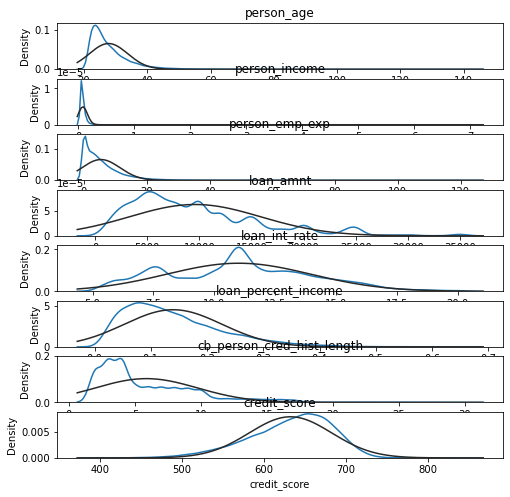

In [150]:
# add kurtosis and skew
# df_cont = df[continous_val].describe()
# df_kurtosis = pd.DataFrame(df_cont.kurtosis()).T.rename(index={0: 'kurtosis'})
# df_skew = pd.DataFrame(df_cont.skew()).T.rename(index={0: 'skew'})
# df_describe = pd.concat([df_cont, df_kurtosis, df_skew], ignore_index=False)
# graph to visualize the distribution of the fields
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(8, 8), nrows=len(continous_val), ncols=1, sharex=False)
for i, col in enumerate(continous_val):
    sns.distplot(df[col], ax=ax[i], kde=True, hist=False, fit=stats.norm)
    ax[i].set_title(col)

Applying square root method

C:\Users\Luiz\AppData\Local\Temp/ipykernel_3240/51373272.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sq[col], hist=False, fit=stats.norm, kde_kws={'label': col}, ax=axs[i])
C:\Users\Luiz\AppData\Local\Temp/ipykernel_3240/51373272.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

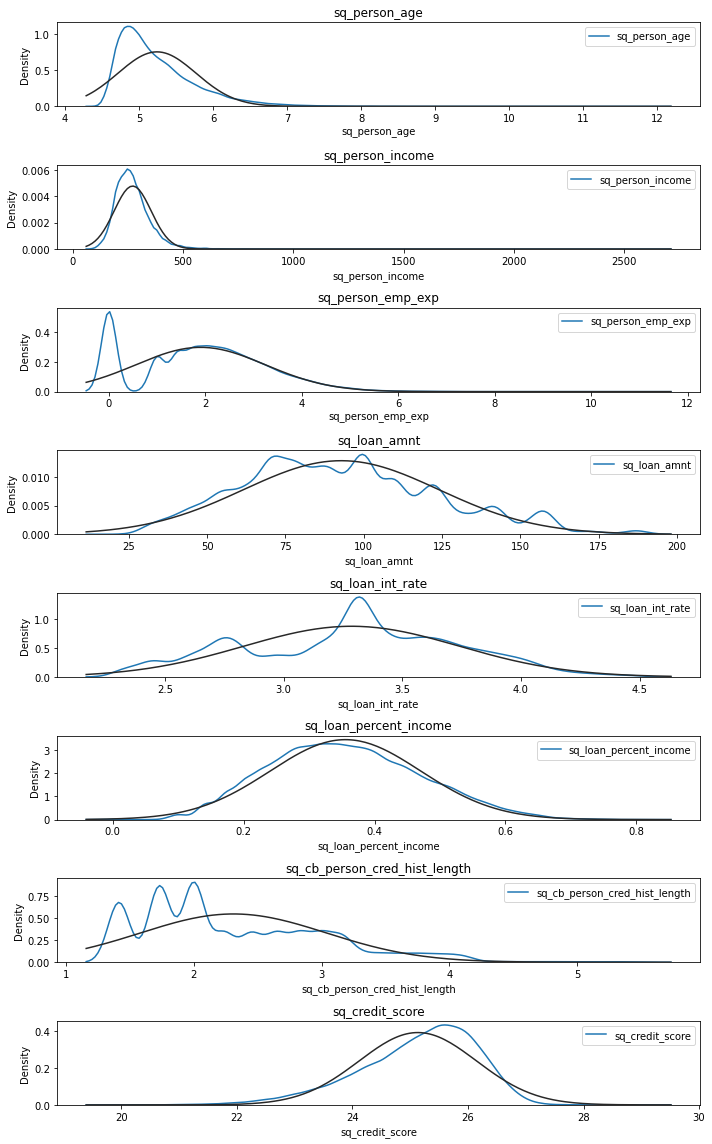

In [ ]:
df_transform = df

continous_val = df_transform.select_dtypes(include=[np.number]).columns
continous_val = [col for col in continous_val if 'sq' not in col]
df_transform[continous_val] = df_transform[continous_val].apply(lambda x: x**0.5)
df_transform.columns

fig, axs = plt.subplots(len(sq_cont_val), figsize=(10, 2*len(sq_cont_val)))
for i, col in enumerate(sq_cont_val):
    sns.distplot(df_sq[col], hist=False, fit=stats.norm, kde_kws={'label': col}, ax=axs[i])
    axs[i].set_title(col)
    axs[i].legend()
plt.tight_layout()
plt.show()

In [161]:
# Skewness -> Squared root transformation
# Kurtosis -> Log transformation
df_sq.describe()
df_kurtosis = pd.DataFrame(df_sq.kurtosis()).T.rename(index={0: 'kurtosis'})
df_skew = pd.DataFrame(df_sq.skew()).T.rename(index={0: 'skew'})
df_sq_stats = pd.concat([df_sq, df_kurtosis, df_skew], ignore_index=False)
df_sq_stats

C:\Users\Luiz\AppData\Local\Temp/ipykernel_3240/2993798306.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_kurtosis = pd.DataFrame(df_sq.kurtosis()).T.rename(index={0: 'kurtosis'})
C:\Users\Luiz\AppData\Local\Temp/ipykernel_3240/2993798306.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_skew = pd.DataFrame(df_sq.skew()).T.rename(index={0: 'skew'})


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,...,previous_loan_defaults_on_file,loan_status,sq_person_age,sq_person_income,sq_person_emp_exp,sq_loan_amnt,sq_loan_int_rate,sq_loan_percent_income,sq_cb_person_cred_hist_length,sq_credit_score
0,4.690416,female,Master,268.231244,0.000000,RENT,187.082869,PERSONAL,4.002499,0.700000,...,No,1.000000,4.690416,268.231244,0.000000,187.082869,4.002499,0.700000,1.732051,23.685439
1,4.582576,female,High School,110.824185,0.000000,OWN,31.622777,EDUCATION,3.337664,0.282843,...,Yes,0.000000,4.582576,110.824185,0.000000,31.622777,3.337664,0.282843,1.414214,22.449944
2,5.000000,female,High School,111.525782,1.732051,MORTGAGE,74.161985,MEDICAL,3.587478,0.663325,...,No,1.000000,5.000000,111.525782,1.732051,74.161985,3.587478,0.663325,1.732051,25.199206
3,4.795832,female,Bachelor,282.405736,0.000000,RENT,187.082869,MEDICAL,3.902563,0.663325,...,No,1.000000,4.795832,282.405736,0.000000,187.082869,3.902563,0.663325,1.414214,25.980762
4,4.898979,male,Master,257.167261,1.000000,RENT,187.082869,MEDICAL,3.777565,0.728011,...,No,1.000000,4.898979,257.167261,1.000000,187.082869,3.777565,0.728011,2.000000,24.207437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44997,5.744563,male,Associate,238.625229,2.645751,RENT,52.640289,DEBTCONSOLIDATION,3.165438,0.223607,...,No,1.000000,5.744563,238.625229,2.645751,52.640289,3.165438,0.223607,3.162278,25.845696
44998,5.385165,male,Bachelor,182.109857,2.000000,RENT,109.544512,EDUCATION,3.637307,0.600000,...,No,1.000000,5.385165,182.109857,2.000000,109.544512,3.637307,0.600000,2.449490,24.576411
44999,4.898979,male,High School,227.176143,1.000000,RENT,81.639451,DEBTCONSOLIDATION,4.129165,0.360555,...,No,1.000000,4.898979,227.176143,1.000000,81.639451,4.129165,0.360555,1.732051,25.059928
kurtosis,5.692427,NaN,NaN,46.183473,-0.164224,NaN,-0.219576,NaN,-0.579065,-0.281191,...,NaN,-0.214176,5.692427,46.183473,-0.164224,-0.219576,-0.579065,-0.281191,0.377698,0.454465


# Kurtosis

In [153]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_describe_scaled = scaler.fit_transform(df_sq)
df_describe_scaled = pd.DataFrame(df_describe_scaled, columns=df_sq.columns)

df_kurtosis = pd.DataFrame(df_sq.kurtosis()).T.rename(index={0: 'kurtosis'})
df_skew = pd.DataFrame(df_sq.skew()).T.rename(index={0: 'skew'})
df_sq_stats = pd.concat([df_sq, df_kurtosis, df_skew], ignore_index=False)
df_sq_stats


# fig, axs = plt.subplots(len(sq_cont_val), figsize=(10, 2*len(sq_cont_val)))
# for i, col in enumerate(sq_cont_val):
#     sns.distplot(df_describe_scaled[col], hist=False, fit=stats.norm, kde_kws={'label': col}, ax=axs[i])
#     axs[i].set_title(col)
#     axs[i].legend()
# plt.tight_layout()
# plt.show()




,sq_person_age,sq_person_income,sq_person_emp_exp,sq_loan_amnt,sq_loan_int_rate,sq_loan_percent_income,sq_cb_person_cred_hist_length,sq_credit_score
count,212.132034,212.132034,212.132034,212.132034,212.132034,212.132034,212.132034,212.132034
mean,5.269172,283.406163,2.326012,97.893603,3.317620,0.373798,2.422290,25.151715
std,2.458680,283.588608,2.462424,79.466261,1.725922,0.295317,1.969696,7.101821
min,4.472136,89.442719,0.000000,22.360680,2.328089,0.000000,1.414214,19.748418
25%,4.898979,217.264815,1.000000,70.710678,2.930870,0.264575,1.732051,24.515301
50%,5.099020,258.936286,2.000000,89.442719,3.318132,0.346410,2.000000,25.298221
75%,5.477226,309.498384,2.828427,110.622104,3.604164,0.435890,2.828427,25.884358
max,12.000000,2683.424305,11.180340,187.082869,4.472136,0.812404,5.477226,29.154759
kurtosis,2.828396,2.827928,2.828397,0.710156,2.828427,2.828427,2.828426,2.827455
skew,1.681780,1.681595,1.681781,1.165099,1.681793,1.681793,1.681792,1.681405


Without transformations
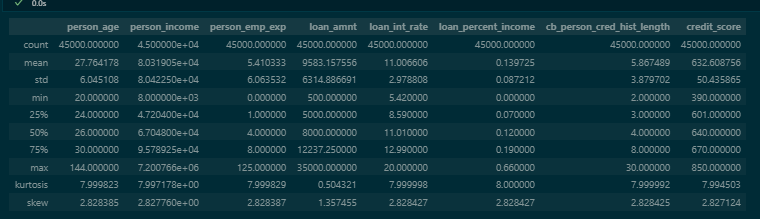

### 1.7.2 Categorical Attributes

In [154]:
# Separate categorical and numerical columns
categorical_val = []
continous_val = []
for column in df.columns:
    if len(df[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

print('categorical', categorical_val)

categorical ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'loan_status']


# 2. Feature Engineering

## 2.1 Hypothesis Mind Mapping

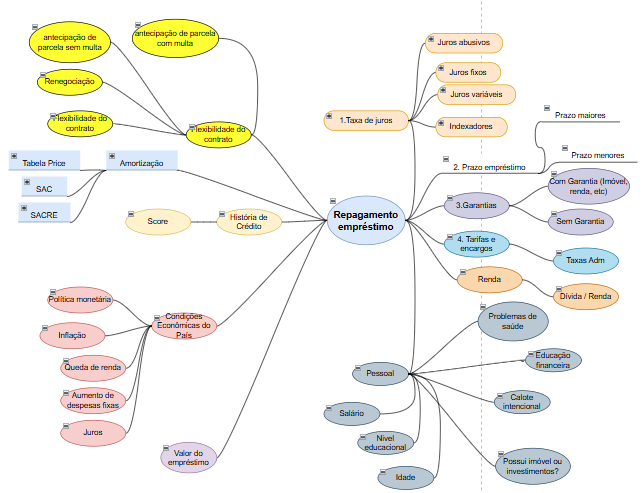

## 2.2 Creating Hypothesis

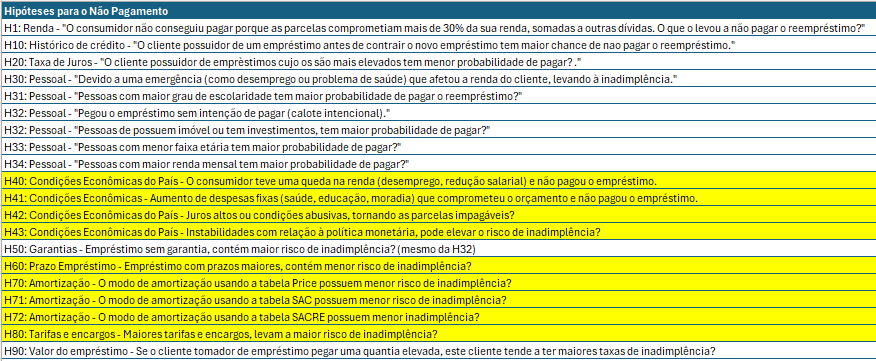

## 2.3 Final Hypothesis


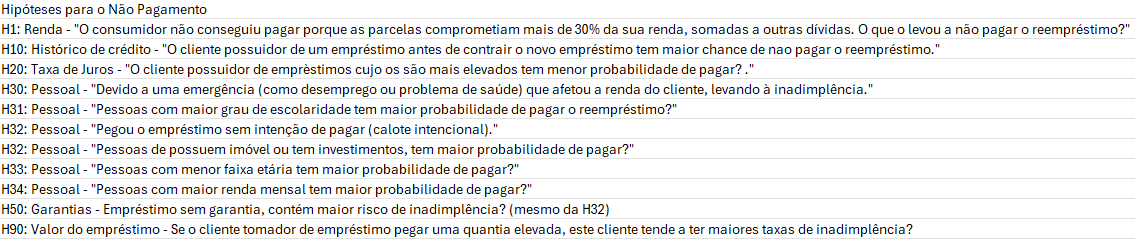

## 2.4 Feature Engineering

# 3.0 FILTER ATTRIBUTES OR ROWS

## 3.1 Filter Rows

In [ ]:
# df = df_skew_kurtosis
# df.columns

Index(['Skew', 'Kurtosis'], dtype='object')

Verifying outiers in numerical variables

In [155]:
import pandas as pd
import numpy as np

# Assuming you have a Pandas DataFrame named 'df'
# and 'continous_val' is a list of names of continuous columns
# and 'loan_status' is a column where 1 represents defaulted loans

# Filter the DataFrame for defaulted loans (loan_status == 1)
defaulted_df = df[df['loan_status'] == 1].copy() # Use .copy() to avoid SettingWithCopyWarning

# Calculate IQR bounds and analyze outliers only in defaulted loans
outlier_analysis = {}

for col in continous_val:
    # Calculate IQR bounds using ONLY the defaulted loans DataFrame
    Q1 = defaulted_df[col].quantile(0.25)
    Q3 = defaulted_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers in defaulted loans
    is_outlier = (defaulted_df[col] < lower_bound) | (defaulted_df[col] > upper_bound)
    defaulted_outliers = defaulted_df[is_outlier]

    # Store results
    outlier_analysis[col] = {
        'Lower Bound (Defaulted)': lower_bound,
        'Upper Bound (Defaulted)': upper_bound,
        'Total Defaulted Loans': len(defaulted_df),
        'Defaulted Outliers': len(defaulted_outliers),
        'Outlier Percentage (%)': (len(defaulted_outliers)/len(defaulted_df))*100 if len(defaulted_df) > 0 else 0
    }

# Convert to DataFrame and display
results_df = pd.DataFrame(outlier_analysis).T
results_df = results_df[['Lower Bound (Defaulted)', 'Upper Bound (Defaulted)', 'Total Defaulted Loans',
                            'Defaulted Outliers', 'Outlier Percentage (%)']]
print(results_df.sort_values('Outlier Percentage (%)', ascending=False))

# Corrected way to get high-risk outliers based on IQR of defaulted loans
outlier_condition = (defaulted_df['loan_int_rate'] < defaulted_df['loan_int_rate'].quantile(0.25) - 1.5 * (defaulted_df['loan_int_rate'].quantile(0.75) - defaulted_df['loan_int_rate'].quantile(0.25))) | \
                    (defaulted_df['loan_int_rate'] > defaulted_df['loan_int_rate'].quantile(0.75) + 1.5 * (defaulted_df['loan_int_rate'].quantile(0.75) - defaulted_df['loan_int_rate'].quantile(0.25)))

high_risk_outliers = defaulted_df[outlier_condition][['loan_int_rate', 'loan_status']]

print(f"\nHigh-risk outliers (defaulted loans with extreme interest rates):\n{high_risk_outliers.head()}")


                            Lower Bound (Defaulted)  Upper Bound (Defaulted)  \
person_income                            -15728.000               124458.000   
person_age                                   12.500                   40.500   
person_emp_exp                               -9.500                   18.500   
cb_person_cred_hist_length                   -4.500                   15.500   
credit_score                                499.000                  771.000   
loan_amnt                                -10000.000                30000.000   
loan_percent_income                          -0.145                    0.535   
loan_int_rate                                 4.630                   21.590   

                            Total Defaulted Loans  Defaulted Outliers  \
person_income                             10000.0               516.0   
person_age                                10000.0               395.0   
person_emp_exp                            10000.0           

Filtrando Outliers de Idade e Tempo de experiência

<AxesSubplot:xlabel='person_age', ylabel='person_emp_exp'>

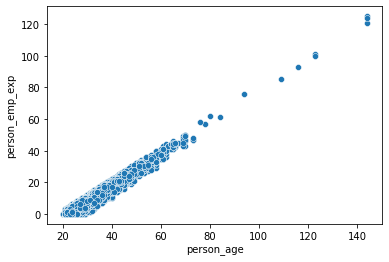

In [32]:
sns.scatterplot(x=df['person_age'], y=df['person_emp_exp'])

In [33]:
# Cleaning the person_age field
df = df[df['person_age']<= 100]
df = df[df['person_emp_exp']<= 60]

<AxesSubplot:xlabel='person_age', ylabel='person_emp_exp'>

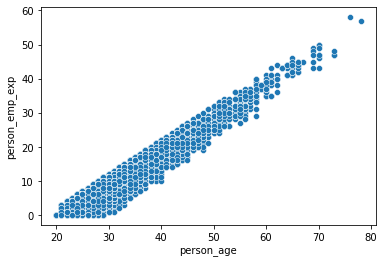

In [34]:
sns.scatterplot(x=df['person_age'], y=df['person_emp_exp'])

Resposta: Parece que os dados são robustos, consegui encontrar uma pessoa com 144 anos. Então, presumi que apenas pessoas com menos ou igual a 100 anos seriam consideradas neste conjunto de dados. Também removi pessoas com mais de 60 anos de experiência, pois parece um dado preenchido incorretamente.

## 3.2 Filter Attributes

# 4.0 EXPLORATORY DATA ANALYSIS (EDA)

## 4.1 Univariate Analysis (Target Variable)


#### 4.1.1 Análise Univariada para verificar a distribuição dos dados do campo loan_status.

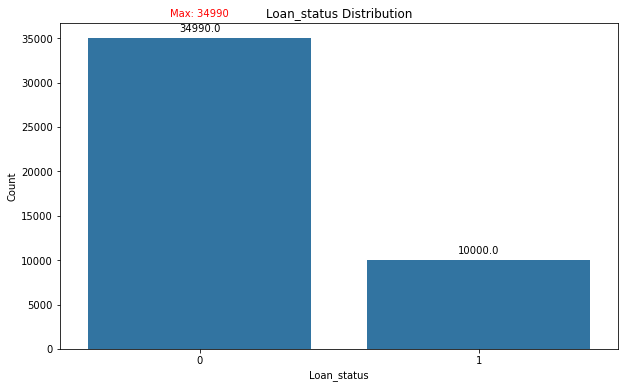

In [35]:
bar_plot_unique_var(df,'loan_status')

#### 4.1.1 Resposta: Não há valores nulos e todos os dados são distintos. Temos 45.000 pessoas no total, 35.000 não pagaram o empréstimo e 10.000 pagaram, então nosso problema é desbalanceado.

## 4.2 Bivariate Analysis (Target versus Attributes)

### 4.2.1 Hipótese: "O consumidor não conseguiu pagar porque as parcelas comprometiam mais de 30% da sua renda, somadas a outras dívidas. O que o levou a não pagar o reempréstimo?"

g:\Meu Drive\AI_ML\loan_payment\graphs\violin_percent.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'0', '1'}

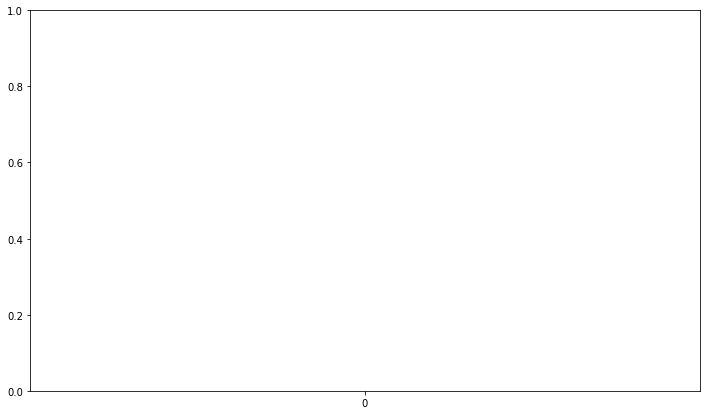

In [36]:
plot_violin_percent("loan_status", "loan_percent_income", df)

### 4.2.1 Resposta: O comprometimento da renda com dívidas para o grupo não pagante predominantemente está entre 11% e 28% da renda. E o grupo pagante possuium comprometimento entre 7% a 16% da renda.

### 4.2.2 Hipótese - "O cliente possuidor de um empréstimo antes de contrair o novo empréstimo tem maior chance de nao pagar o reempréstimo."

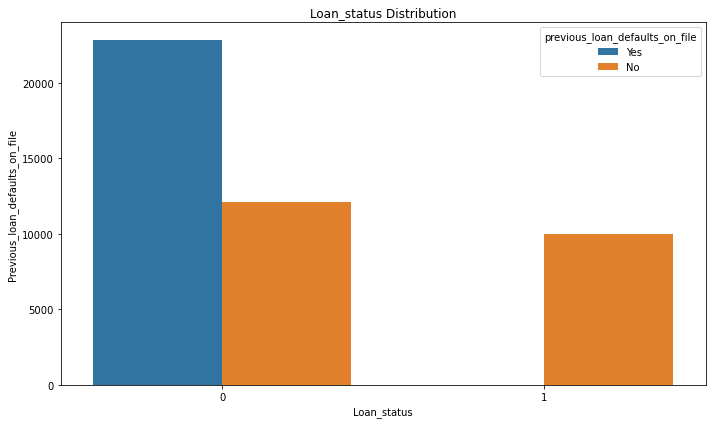

In [37]:
bar_plot_nominal(df, 'loan_status','previous_loan_defaults_on_file')

### 4.2.2 Resposta: Clientes que possuem empréstimos anteriores tem menor probabilidade de pagar o empréstimo atual. E podemos dizer que os clientes sem empréstimos anteriores tem maior probabilidade de pagar o empréstimo atual.

### 4.2.3 Hipótese: "O cliente possuidor de emprèstimos cujo os são mais elevados tem menor probabilidade de pagar?"

g:\Meu Drive\AI_ML\loan_payment\graphs\violin_percent.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'0', '1'}

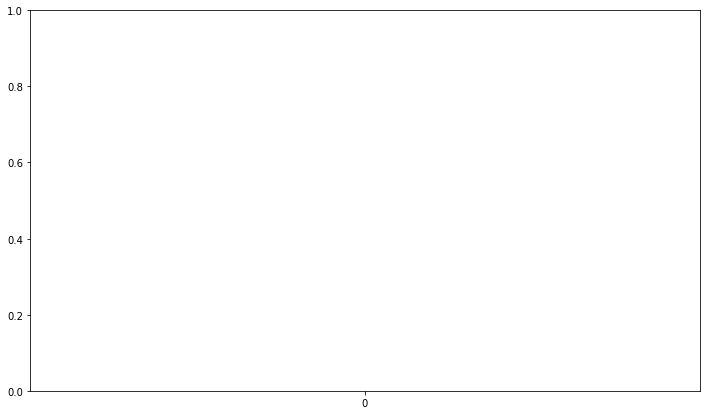

In [38]:
plot_violin_percent("loan_status", "loan_int_rate", df)

### 4.2.3 Hipótese: Este gráfico sugere que existe uma correlação entre taxas de juros mais altas e menor probabilidade de pagamento, possivelmente porque juros elevados tornam as parcelas mais pesadas no orçamento dos clientes, aumentando o risco de inadimplência.

### 4.2.4  Hipótese: "Devido a uma emergência (problema de saúde) que afetou a renda do cliente, levando à inadimplência."

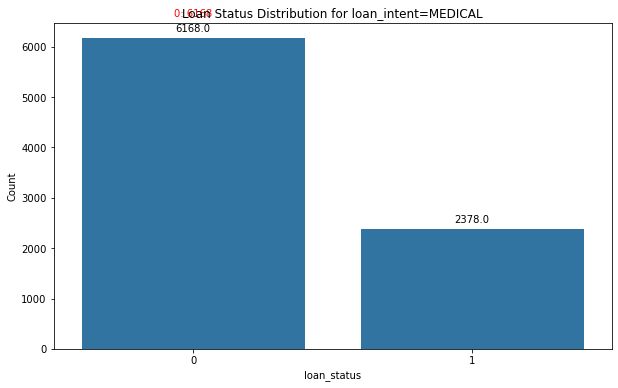

In [39]:
bar_plot_ordinal(df, 'MEDICAL','loan_intent','loan_status')

### 4.2.4 Reposta: Este gráfico demonstração de existe uma maior probabilidade de não repagamento dos empréstimos por parte do clientes quando o motivo é por condição médica.  

### 4.2.5 Hipótese:"Pessoas com maior grau de escolaridade tem maior probabilidade de pagar?"

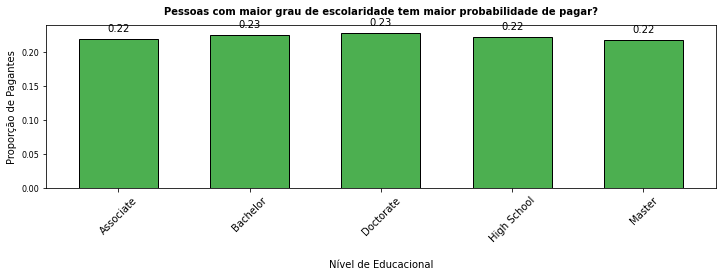

In [40]:
bar_plot_index(df,'person_education','loan_status')

### 2.4.5. Resposta: O nível educacional não altera significativamente a probabilidade de repagamento do empréstimo.

### 4.2.6 Hipótese:"Pessoas de possuem imóveis ou tem investimentos, tem maior probabilidade de pagar?"

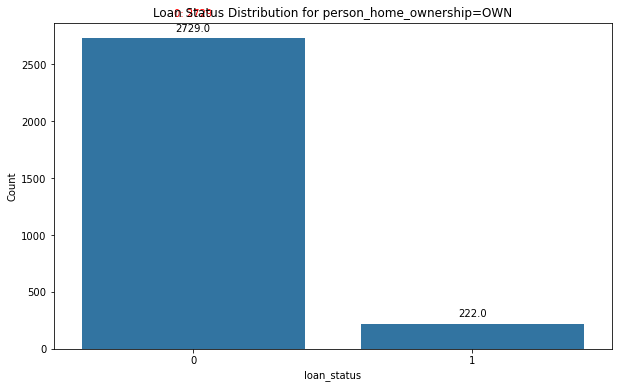

In [41]:
bar_plot_ordinal(df,'OWN','person_home_ownership', 'loan_status')

### 4.2.6 Resposta: "Pessoas de possuem imóvel tem maior probabilidade de não pagar o reempréstimo."

### 4.2.7 Hipótese: "Pessoas com menor faixa etária tem maior probabilidade de pagar?"

g:\Meu Drive\AI_ML\loan_payment\graphs\violin_log.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'0', '1'}

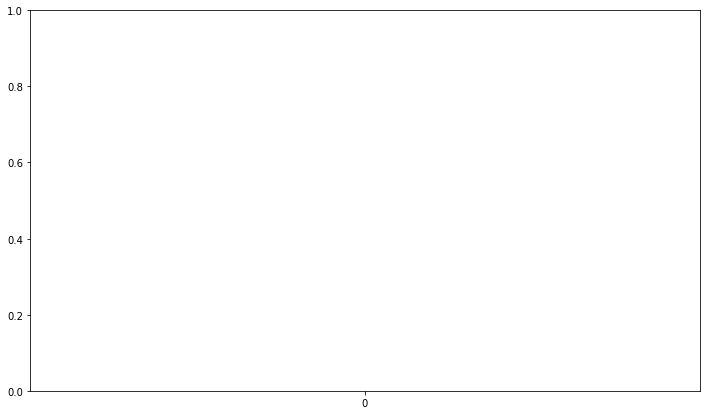

In [42]:
plot_violin_log('loan_status','person_age',df)

### 4.2.7 Resposta: Não podemos afirmar que pessoas com menor faixa etária tem maior probabilidade de pagar o empréstimo.

### 4.2.8 Hipótese: "Pessoas com maior renda mensal tem maior probabilidade de pagar?"

g:\Meu Drive\AI_ML\loan_payment\graphs\violin_log.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'0', '1'}

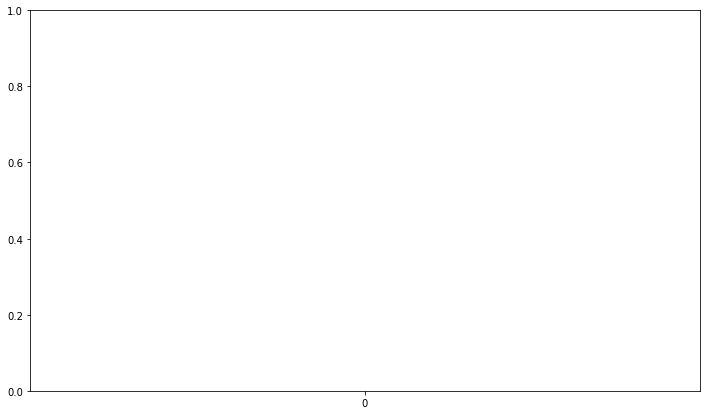

In [43]:
plot_violin_log('loan_status','person_income',df)

### 4.2.8 Resposta: Pessoas com maiores rendas tendem a pagar os reempréstimos.

### 4.2.9 Hipótese: "O cliente possuidor de emprèstimos cujo os são mais elevados tem menor probabilidade de pagar?"





g:\Meu Drive\AI_ML\loan_payment\graphs\violin.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'0', '1'}

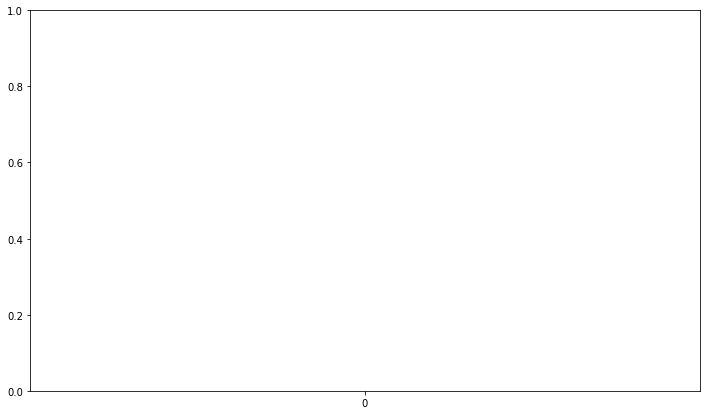

In [44]:
plot_violin('loan_status','loan_amnt',df)

### 4.2.9 Resposta: "O cliente possuidor de emprèstimos pagantes tem valores menores de emprèstimos."


### 4.2.10 Hipótese: "Pegou o empréstimo sem intenção de pagar (calote intencional), medir via histórico de empréstimos"

g:\Meu Drive\AI_ML\loan_payment\graphs\violin.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'0', '1'}

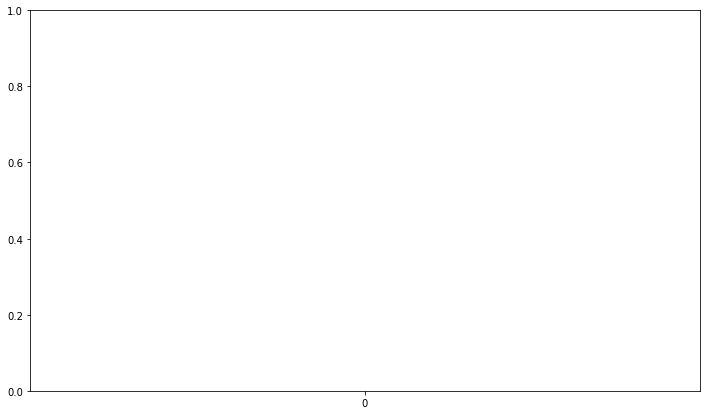

In [45]:
plot_violin('loan_status', 'credit_score', df)

### 4.2.10 Resposta: "O histórico de pagante e não pagante muito similar, não havendo diferença entre os dois em termos de o empréstimo sem intenção de pagar (calote intencional), medir via histórico de empréstimos"

## 4.3 Multivariate Analysis (Correlation)

# 5.0 DATA PREPARATION

## 5.1 Normalization


Logistic Regression, SVM (with RBF kernel), K-Nearest Neighbors (KNN), Neural Networks and PCA requires normalization.

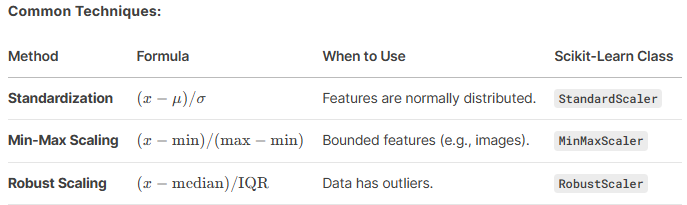

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# # Standardization (assumes normal distribution)
# scaler = StandardScaler()
# X_train_std = scaler.fit_transform(X_train)
# X_test_std = scaler.transform(X_test)

# # Min-Max Scaling (scales to [0, 1])
# scaler = MinMaxScaler()
# X_train_mm = scaler.fit_transform(X_train)
# X_test_mm = scaler.transform(X_test)

# # Robust Scaling (for outlier-resistant scaling)
# scaler = RobustScaler()
# X_train_robust = scaler.fit_transform(X_train)
# X_test_robust = scaler.transform(X_test)

## 5.2 Standartization

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data


NameError: name 'X_train' is not defined

## 5.3 Transformation

### 5.3.1 One Hot Encoding - Categorical Values

In [ ]:
# One-hot encoding
df = pd.get_dummies(df,drop_first=True,dtype='int8')
df.head(5)

# 6.0 FEATURE SELECTION

## 6.1 Data Split

### 6.1.1 Random_state em suas funções de divisão para reprodutibilidade e stratify habilitado. (70% treinamento, 15% validação, 15% teste)
Quando usar estratificar?
Problemas de classificação (não regressão).

Ao lidar com conjuntos de dados desbalanceados.

Para garantir uma avaliação justa do desempenho do modelo em todas as classes.

In [ ]:
# Drop target column
X = df.drop(columns=['loan_status'], axis=1)

# Dataframe is only the target field
y = df['loan_status']
# print(y.describe())

# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=27,
    stratify=y  # Preserve class ratios
)

# Second split: 50% of temp -> 15% val, 15% test (of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=27,
    stratify=y_temp  # Stratify on the temporary split
)

# Verify sizes
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X):.0%})")
print(f"Val:   {len(X_val)} samples ({len(X_val)/len(X):.0%})")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X):.0%})")

# Verify class distribution
def check_distribution(y_data, name):
    classes, counts = np.unique(y_data, return_counts=True)
    print(f"\n{name} class distribution:")
    for cls, count in zip(classes, counts):
        print(f"Class {cls}: {count} samples ({count/len(y_data):.1%})")

check_distribution(y_train, "Training")
check_distribution(y_val, "Validation")
check_distribution(y_test, "Test")

## 6.2 Manual Feature Selection

## tabela com os campos selecionados na EDA

## 6.3 Automatic Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from boruta import BorutaPy

# Implement Random Forest Model with Boruta feature selection
rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(X_train.values, y_train.values.ravel())

# Transform datasets to only include selected features
sel_X_train = boruta_selector.transform(X_train.values)
sel_X_test = boruta_selector.transform(X_test.values)

# Get selected features
selected_feature_mask = boruta_selector.support_
selected_features = X_train.columns[selected_feature_mask]

# Train final model on selected features
rfc_final = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42)
rfc_final.fit(sel_X_train, y_train.values.ravel())

# Make predictions
y_pred = rfc_final.predict(sel_X_test)
y_pred_proba = rfc_final.predict_proba(sel_X_test)[:, 1]  # Probabilities for positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

# 7.0 MACHINE LEARNING MODELING

## 7.1 Model Baseline



In [ ]:
# Strategy 1: Predict most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_baseline = dummy_clf.predict(X_test)


# Train and evaluate the model
results_baseline = train_xgb(X_train, X_test, y_train, y_test, results_dict)

print(results_dict)

## 7.2 Linear Models

In [ ]:
# Regressão
def train_log_reg(X_train_scaled, X_test_scaled, y_train, y_test, results_dict):
    """Train a Logistic Regression model and evaluate its performance."""
    log_reg = LogisticRegression(solver='liblinear')
    log_reg.fit(X_train_scaled, y_train)
    y_pred = log_reg.predict(X_test_scaled)
    y_proba = log_reg.predict_proba(X_test_scaled)
    results = evaluate_model(y_test, y_pred, y_proba)
    results_dict['Logistic Regression'].append(results)
    return results


# Train and evaluate the model
results_log_reg = train_log_reg(X_train_scaled, X_test_scaled, y_train, y_test, results_dict)


## 7.3 Non-Linear Models

In [ ]:
# K-Nearest Neighbors
def train_knn(X_train_scaled, X_test_scaled, y_train, y_test, results_dict):
    """
    Train a K-Nearest Neighbors classifier and evaluate its performance.
    """
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    y_proba = knn.predict_proba(X_test_scaled)
    results = evaluate_model(y_test, y_pred, y_proba)
    results_dict['KNN'].append(results)
    return results

# Decision Tree
def train_dec_tree(X_train, X_test, y_train, y_test, results_dict):
    """Train a Decision Tree Classifier model and evaluate its performance."""
    dec_tree = DecisionTreeClassifier(random_state=42)
    dec_tree.fit(X_train, y_train)

    y_pred = dec_tree.predict(X_test)
    y_proba = dec_tree.predict_proba(X_test)
    results = evaluate_model(y_test, y_pred, y_proba)
    results_dict['Decision Tree'].append(results)
    return results

# Random Forest
def train_rand_for(X_train, X_test, y_train, y_test, results_dict):
    """Train a Random Forest Classifier model and evaluate its performance."""
    rand_for = RandomForestClassifier(n_estimators=1000, random_state=42)
    rand_for.fit(X_train, y_train)
    y_pred = rand_for.predict(X_test)
    y_proba = rand_for.predict_proba(X_test)
    results = evaluate_model(y_test, y_pred, y_proba)
    results_dict['Random Forest'].append(results)
    return results


def train_xgb(X_train, X_test, y_train, y_test, results_dict):
    """Train an XGBoost Classifier model and evaluate its performance."""
    # Initialize and train XGBoost model with fixed parameters
    xgb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    xgb.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)

    results = evaluate_model(y_test, y_pred, y_proba)
    results_dict['XGBoost'].append(results)
    return results



results_knn = train_knn(X_train_scaled, X_test_scaled, y_train, y_test, results_dict)

results_dec_tree = train_dec_tree(X_train, X_test, y_train, y_test, results_dict)
# Train and evaluate the model
results_rand_for = train_rand_for(X_train, X_test, y_train, y_test, results_dict)

# Train and evaluate the model
results_xgb = train_xgb(X_train, X_test, y_train, y_test, results_dict)

print(results_dict)



## 7.4 Cross-validation (get mean value)

In [ ]:
# K-Fold Cross-Validation (5 folds)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    model, X_train, y_train, cv=kf, scoring='accuracy'
)

print("\nCross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

In [ ]:
# Extract the first (and in this case, only) dictionary of metrics for each algorithm
metrics_list = []
for model, metrics in results_dict.items():
    first_metric_set = metrics[0]
    first_metric_set['Algorithm'] = model
    metrics_list.append(first_metric_set)

# Create a Pandas DataFrame from the list of metrics
df = pd.DataFrame(metrics_list)

# Set the 'Algorithm' column as the index for better readability
df.set_index('Algorithm', inplace=True)

# Print the DataFrame as a formatted table
print(df.to_markdown())

# 8.0 Hypermeter Fine-tuning

## 8.1 Grid search/Random Search/Bayesing Search

In [ ]:
# 1. Grid Search (Exhaustive)
# ---
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# ---
# 2. Random Search (Random Sampling)
# ---
param_dist = {
    'clf__n_estimators': np.arange(50, 300, 50),
    'clf__max_depth': [None] + list(np.arange(5, 30, 5)),
    'clf__min_samples_split': np.arange(2, 11),
}
random_search = RandomizedSearchCV(
    pipe, param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

# ---
# 3. Bayesian Optimization (Smart Search)
# ---
bayes_space = {
    'clf__n_estimators': Integer(50, 300),
    'clf__max_depth': Integer(5, 30),
    'clf__min_samples_split': Integer(2, 10),
}
bayes_search = BayesSearchCV(
    pipe, bayes_space, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
bayes_search.fit(X_train, y_train)

# ---
# Results Comparison
# ---
def evaluate(search, name):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"\n{name}:")
    print(f"Best Params: {search.best_params_}")
    print(f"CV Accuracy: {search.best_score_:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

evaluate(grid_search, "Grid Search")
evaluate(random_search, "Random Search")
evaluate(bayes_search, "Bayesian Optimization")

## 8.2 Final Model (champion model)

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DE ERROS

# 10.0 DEPLOY (APPLICATION)